# Question 1: Gibbs Sampler

Here, we will draw from the multivariate normal with a Gibbs sampler. The variable $X$ (changed from $Y$ originally) is distributed as:
$$
Y \sim \mathcal{N}\left( 
\begin{bmatrix}
1 \\
2 \\
3 \\
\end{bmatrix},
\begin{bmatrix}
4 & 1.2 & 1.2 \\
1.2 & 4 & 1.2 \\
1.2 & 1.2 & 4 \\
\end{bmatrix}
\right)
$$

## a.

Write out the relevant conditional distributions to sample from for the Gibbs sampler.

We first note that our samples will come from a 3-dimensional multivariate normal distribution. For the Gibbs sampler, we will need to find the conditional distributions $x_i \vert x_{-i}$ for each $i = 1,2,3$.

We will apply Geweke's result on the conditional distribution for the multivariate normal distribution. Namely, we will have that
$$
\begin{pmatrix}
x_i \\
x_{-i} \\
\end{pmatrix}
\sim \mathcal{N}(\mu, \Sigma)
$$
with $ \mu = 
\begin{pmatrix}
\mu_i \\
\mu_{-i} \\
\end{pmatrix} $ 
and $ \Sigma = 
\begin{pmatrix}
\Sigma_{i,i} & \Sigma_{i,-i} \\
\Sigma_{-i,i} & \Sigma_{-i,-i} \\
\end{pmatrix} $.

Then, the conditional distribution of $x_i$ given $x_{-i}$ will be given by:
$$
x_i \vert x_{-i} \sim \mathcal{N}(\mu_{i \vert -i}, \Sigma_{i \vert -i})
$$
where
$$
\mu_{i \vert -i} = \mu_i + \Sigma_{i,-i}{\Sigma_{-i,-i}}^{-1}(x_{-i} - \mu_{-i})
$$
$$
\Sigma_{i \vert -i} = \Sigma_{i,i} - \Sigma_{i,-i}{\Sigma_{-i,-i}}^{-1}\Sigma_{-i,i}
$$


For example, for $x_1$, we would have:
$$
x_1 \vert x_{-1} \sim \mathcal{N}(\mu_1 + \Sigma_{1,-1}{\Sigma_{-1,-1}}^{-1}(x_{-1} - \mu_{-1}), \Sigma_{1,1} - \Sigma_{1,-1}{\Sigma_{-1,-1}}^{-1}\Sigma_{-1,1})
$$

We will now use Python to find the exact values of the conditional means and covariances. 

In [1]:
# Import libraries
import numpy as np
import random
import matplotlib.pyplot as plt
from emcee.autocorr import integrated_time
%matplotlib inline

In [2]:
# Define class to make a particular distribution from which to Gibbs sample
# Can specify a multivariate normal mean and covariance parameter
class Conditional:
    
    def __init__(self, mean, covariance):
        self.m = covariance.shape[0]
        self.n = covariance.shape[1] 
        self.mean = mean
        self.covar = covariance        
    
    def cond_mean(self, i, x):
        j = i - 1    # For ease of notation since Python is 0-indexed
        sigma_i_minus_i = np.delete(self.covar[j, :], j)
        sigma_minus_i_minus_i = np.delete(np.delete(self.covar, j, axis = 0), j, axis = 1)
        return self.mean[j] + np.matmul(np.matmul(sigma_i_minus_i, np.linalg.inv(sigma_minus_i_minus_i)), (np.delete(x, j) - np.delete(self.mean, j)))
    
    def cond_covar(self, i):
        j = i - 1    # For ease of notation since Python is 0-indexed
        sigma_i_minus_i = np.delete(self.covar[j, :], j)
        sigma_minus_i_minus_i = np.delete(np.delete(self.covar, j, axis = 0), j, axis = 1) 
        sigma_minus_i_i = np.delete(sigma[:, j], j).reshape(self.m-1, 1)
        return sigma[j, j] - (np.matmul(np.matmul(sigma_i_minus_i, np.linalg.inv(sigma_minus_i_minus_i)), sigma_minus_i_i))


In [3]:
mu = np.array([1,2,3])
mu

array([1, 2, 3])

In [4]:
sigma = np.array([[4, 1.2, 1.2], [1.2, 4, 1.2], [1.2, 1.2, 4]])
sigma

array([[4. , 1.2, 1.2],
       [1.2, 4. , 1.2],
       [1.2, 1.2, 4. ]])

In [5]:
# sigma_{i, i}
sigma[1, 1]

4.0

In [6]:
# sigma_{i, -i}
np.delete(sigma[1, :], 1)

array([1.2, 1.2])

In [7]:
# sigma_{-i, i}
np.delete(sigma[:, 1], 1).reshape(2, 1)

array([[1.2],
       [1.2]])

In [8]:
# sigma_{-i, -i}
np.delete(np.delete(sigma, 1, axis = 0), 1, axis = 1)

array([[4. , 1.2],
       [1.2, 4. ]])

In [9]:
# first row of sigma
np.append(sigma[1, 1], np.delete(sigma[1, :], 1))

array([4. , 1.2, 1.2])

In [10]:
# second + third rows of sigma
np.concatenate((np.delete(sigma[:, 1], 1).reshape(2, 1), np.delete(np.delete(sigma, 1, axis = 0), 1, axis = 1)), axis = 1)

array([[1.2, 4. , 1.2],
       [1.2, 1.2, 4. ]])

In [11]:
# Sigma
np.vstack([np.append(sigma[1, 1], np.delete(sigma[1, :], 1)), np.concatenate((np.delete(sigma[:, 1], 1).reshape(2, 1), np.delete(np.delete(sigma, 1, axis = 0), 1, axis = 1)), axis = 1).reshape((2, 3))])
#np.vstack([np.append(self.covar[j, j], np.delete(self.covar[j, :], j)), np.concatenate((np.delete(self.covar[:, j], j).reshape(self.m-1, 1), np.delete(np.delete(self.covar, j, axis = 0), j, axis = 1)), axis = 1).reshape((self.m-1, self.n))])

array([[4. , 1.2, 1.2],
       [1.2, 4. , 1.2],
       [1.2, 1.2, 4. ]])

In [12]:
# Find cond'l normal distrib. parameters for each x_i given x_{-i}
x1 = Conditional(mu, sigma)
# Test
print(x1)
print(x1.cond_mean(1, np.zeros((3,))))
print(x1.cond_mean(2, np.zeros((3,))))
print(x1.cond_mean(3, np.zeros((3,))))
print(x1.cond_covar(1, ))
print(x1.cond_covar(2, ))
print(x1.cond_covar(3, ))

-0.15384615384615374
1.076923076923077
2.3076923076923075
[3.44615385]
[3.44615385]
[3.44615385]


That is,
$$
x_1 \vert x_{-1} := x_2,x_3 \sim \mathcal{N}(-0.15384615384615374, 3.44615385)
$$
$$
x_2 \vert x_{-2} := x_1,x_3 \sim \mathcal{N}(1.076923076923077, 3.44615385)
$$
$$
x_3 \vert x_{-3} := x_1,x_2 \sim \mathcal{N}(2.3076923076923075, 3.44615385)
$$

Note that the covariance for each of the 3 conditional distributions will be equal to the same *scalar* value (since we have a symmetric covariance matrix in the first place.

## b.

Implement a Gibbs sampler for the distribution. Explain any modeling choices.

In [13]:
# Gibbs sampler
N = 27000
count = 0
distrib = Conditional(mu, sigma)
x = np.zeros((N, 3))
x_current = x[0, ]

while count < N:
    for i in range(3):
        mean = distrib.cond_mean(i+1, x_current)
        sd = np.sqrt(distrib.cond_covar(i+1, ))
        
        # Sample from conditional normal distribution
        sample_i = sd * np.random.randn() + mean
        #print(x_current)
        x_current[i] = sample_i
        
    x[count, ] = x_current  
    count += 1

In [14]:
x

array([[-1.81059194, -0.19353534,  1.16033892],
       [ 2.67067548,  5.9462859 ,  2.6299407 ],
       [ 3.40935469,  0.97964333,  3.56667087],
       ...,
       [-0.80943649,  4.88728436,  1.99967503],
       [ 6.84367856,  1.54538377,  5.89364279],
       [-1.81059194, -0.19353534,  1.16033892]])

In [15]:
np.mean(x, axis = 0)

array([1.01752357, 1.99962905, 2.99798828])

## c.

Choose a thinning parameter, burn-in factor and total number of iterations that allow you to take 10000 non-autocorrelated draws of the distribution. You may use built-in packages to estimate the integrated autocorrelation time, and other metrics of convergence. Explain your choices.

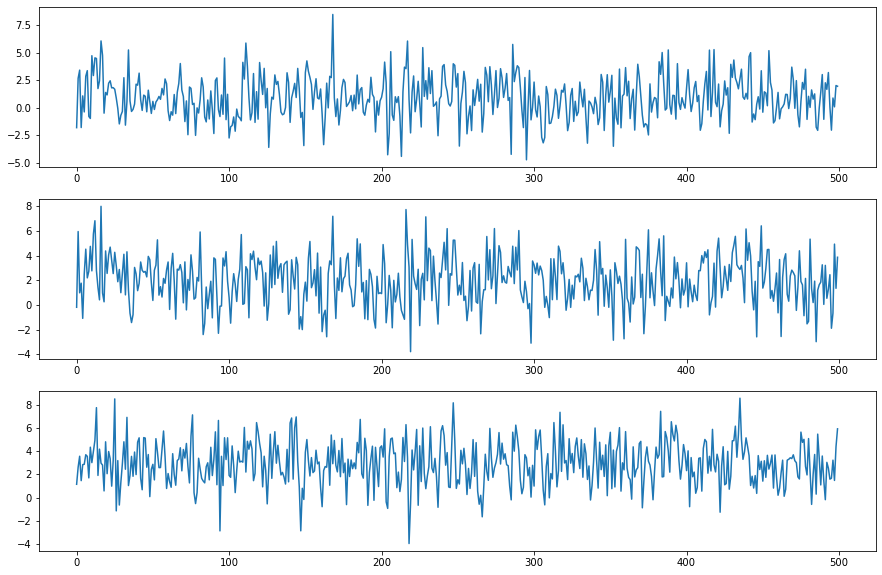

In [16]:
# Trace plots 
x1 = x[:, 0]
x2 = x[:, 1]
x3 = x[:, 2]

fig, ax = plt.subplots(figsize=(15, 10), nrows=3)
ax[0].plot(x1[:500])
ax[1].plot(x2[:500])
ax[2].plot(x3[:500])

In [17]:
burnin = 100

We choose a burn-in above (100) just to be extra safe with regards to the convergence behaviour of our sampler.

In [18]:
# Find integrated autocorrelation times (IAT) for each of the 3 variables/coordinates
tau_x1 = integrated_time(x1[burnin:])
tau_x2 = integrated_time(x2[burnin:])
tau_x3 = integrated_time(x3[burnin:])

In [19]:
# Find the effective sample size
ESS = N / (2 * tau_x1)
print(ESS)

[9891.58089017]


In [20]:
# Find the thinning parameter
thinning_parameter = int(N / ESS)
thinning_parameter

2

Roughly 27,000 total iterations would do the trick - allow us to get 10,000 non-autocorrelated draws

In [21]:
# Implement thinning
thin_chain = x1[burnin:][::thinning_parameter]

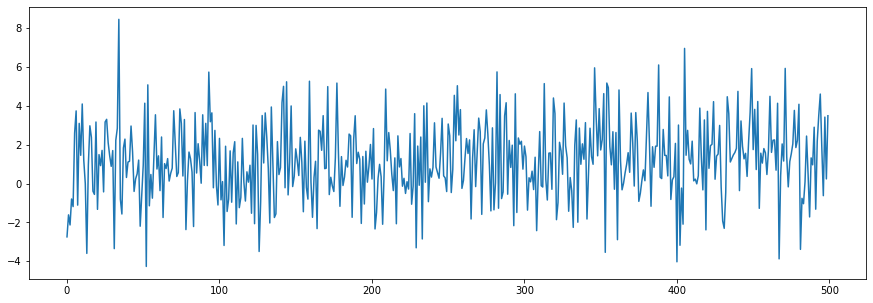

In [22]:
# Trace plot after thinning
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(thin_chain[:500])

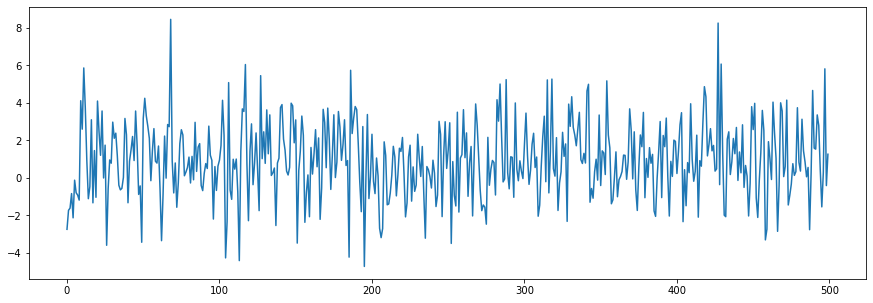

In [23]:
# Versus the original chain
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(x1[burnin:][:500])

Above we can see the trace plots for both the original Markov chain and the chain after thinning; the convergence in both cases is pretty identical, with good convergence behaviour to a stationary distribution almost instantly.